<a href="https://colab.research.google.com/github/stevecwb/Termodinamica-2/blob/main/%5BEQ515%5D_Trabalho_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Grupo 6: 1-butantol e Água

* Estevão S. Rodrigues 168030
* Juliana P. Imark 176224
* Maria E. O. Silva 183614
* Pedro P. F Vidal 187162
* Vitor T. Fidry 195317



## Bibliotecas Importadas

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import fsolve
from sklearn.metrics import r2_score, mean_squared_error

## Parâmetros de Entrada

In [63]:
r_1 = 0.9200 # água
q_1 = 1.400 # água
r_2 = 3.4543 # butanol
q_2 = 3.052 # butanol
Delta11 = 0
Delta12 = 1607.90 ##u12-u22
Delta21 = 1079.38 #u21-u11
Delta22 = 0
R = 8.314
P = 101.33*1000 #Pa
Tc_1 = 647.3
Pc_1 = 220.64*100000 #Pa
w_1 = 0.344
k_1 = 0.37464 + 1.54226*w_1 - 0.26992*(w_1**2)
aTc_1 = (0.45724*(R**2)*(Tc_1**2))/(Pc_1)
b_1 = (0.07780*R*Tc_1)/(Pc_1)
Tc_2 = 563.1
Pc_2 = 44.2*100000 #Pa
w_2 = 0.593
k_2 = 0.37464 + 1.54226*w_2 - 0.26992*(w_2**2)
aTc_2 = (0.45724*(R**2)*(Tc_2**2))/(Pc_2)
b_2 = (0.07780*R*Tc_2)/(Pc_2)
vol1 = 18*10**(-6)
vol2 = 91.5*10**(-6)

## Definição das Funções Usadas

In [64]:
def Antoine_Water(T):
  if T >= 379 and T <= 573:
    A = 3.55959
    B = 643.748
    C = -198.043
  elif T >= 255.9 and T < 379:
    A = 4.6543
    B = 1435.264
    C = -64.848
  P_sat = 10**(A - ((B)/(T + C)))
  return P_sat*100000 #Pa

def Antoine_Butanol(T):
  if T >= 295.8 and T <= 391.0:
    A = 4.54607
    B = 1351.555
    C = -93.34
    P_sat = 10**(A - ((B)/(T + C)))
  return P_sat*100000 #Pa

def Peng_Robinson_Water(T):
  R = 8.314
  Tr = T/Tc_1
  aTr = aTc_1*((1 + k_1*(1 - (Tr**0.5)))**2)
  v = (R*T)/P
  f = (R*T)/(v-b_1) - (aTr)/(v*(v+b_1) + b_1*(v-b_1)) - P
  while abs(f) >= 10**(-5):
    df = (-R*T)/((v-b_1)**2) + (aTr*(2*v + 2*b_1))/((v*(v+b_1) + b_1*(v-b_1))**2)
    v = v - f/df
    f = (R*T)/(v-b_1) - (aTr)/(v*(v+b_1) + b_1*(v-b_1)) - P
  return [aTr, v]

def Peng_Robinson_Butanol(T):
  R = 8.314
  Tr = T/Tc_2
  aTr = aTc_2*((1 + k_2*(1 - (Tr**0.5)))**2)
  v = (R*T)/P
  f = (R*T)/(v-b_2) - (aTr)/(v*(v+b_2) + b_2*(v-b_2)) - P
  while abs(f) >= 10**(-5):
    df = (-R*T)/((v-b_2)**2) + (aTr*(2*v + 2*b_2))/((v*(v+b_2) + b_2*(v-b_2))**2)
    v = v - f/df
    f = (R*T)/(v-b_2) - (aTr)/(v*(v+b_2) + b_2*(v-b_2)) - P
  return [aTr, v]

def Peng_Robinson_Mixture(T, x1):
  x2 = 1 - x1
  aTr_1, v_1 = Peng_Robinson_Water(T)
  aTr_2, v_2 = Peng_Robinson_Butanol(T)
  b12 = ((b_1**2 + b_2**2)/2)**0.5
  a12 = ((aTr_1*aTr_2)**0.5)*((b_1*b_2)/(b12**2))
  Z = ((P)/(R*T))*((v_1 + v_2)/2)
  B = ((P)/(R*T))*((b_1 + b_2)/2)
  A = ((P)/((R*T)**2))*((aTr_1 + aTr_2)/2)
  B_1 = ((P)/(R*T))*(2*(x1*b_1 + x2*b12) - b_1)
  A_1 = ((P)/((R*T)**2))*((x1*aTr_1 + x2*a12))
  B_2 = ((P)/(R*T))*(2*(x1*b12 + x2*b_2) - b_2)
  A_2 = ((P)/((R*T)**2))*((x1*a12 + x2*aTr_2))
  phi1 = np.exp(-np.log(Z - B) + (Z-1)*((B_1)/(B)) - ((A)/(B*(8**0.5)))*(np.log((Z + B*(1+2**0.5))/(Z + B*(1-2**0.5))))*((2*A_1)/(A) - (B_1)/(B)))
  phi2 = np.exp(-np.log(Z - B) + (Z-1)*((B_2)/(B)) - ((A)/(B*(8**0.5)))*(np.log((Z + B*(1+2**0.5))/(Z + B*(1-2**0.5))))*((2*A_2)/(A) - (B_2)/(B)))
  return [phi1, phi2]

def Peng_Robinson_PhiSat(T, Psat):
  R = 8.314
  Tr1 = T/Tc_1
  Tr2 = T/Tc_2
  aTr1 = aTc_1*((1 + k_1*(1 - (Tr1**0.5)))**2)
  aTr2 = aTc_2*((1 + k_2*(1 - (Tr2**0.5)))**2)
  v1 = (R*T)/Psat
  v2 = (R*T)/Psat
  f1 = (R*T)/(v1-b_1) - (aTr1)/(v1*(v1+b_1) + b_1*(v1-b_1)) - Psat
  f2 = (R*T)/(v2-b_2) - (aTr2)/(v2*(v2+b_2) + b_2*(v2-b_2)) - Psat
  while abs(f1) >= 10**(-5):
    df1 = (-R*T)/((v1-b_1)**2) + (aTr1*(2*v1 + 2*b_1))/((v1*(v1+b_1) + b_1*(v1-b_1))**2)
    v1 = v1 - f1/df1
    f1 = (R*T)/(v1-b_1) - (aTr1)/(v1*(v1+b_1) + b_1*(v1-b_1)) - Psat
    
  while abs(f2) >= 10**(-5):
    df2 = (-R*T)/((v2-b_2)**2) + (aTr2*(2*v2 + 2*b_2))/((v2*(v2+b_2) + b_2*(v2-b_2))**2)
    v2 = v2 - f2/df2
    f2 = (R*T)/(v2-b_2) - (aTr2)/(v2*(v2+b_2) + b_2*(v2-b_2)) - Psat

  z1 = (Psat*v1)/(R*T)
  z2 = (Psat*v2)/(R*T)
  A1 = (aTr1*Psat)/((R*T)**2)
  A2 = (aTr2*Psat)/((R*T)**2)
  B1 = (b_1*Psat)/(R*T)
  B2 = (b_2*Psat)/(R*T)
  phisat1 = np.exp((z1 - 1) - np.log(z1 - B1) - ((A1)/(B1*(8**0.5)))*(np.log((z1 + B1*(1+(8**0.5)/2))/(z1 + B1*(1-(8**0.5)/2)))))
  phisat2 = np.exp((z2 - 1) - np.log(z2 - B1) - ((A2)/(B2*(8**0.5)))*(np.log((z2 + B2*(1+(8**0.5)/2))/(z2 + B2*(1-(8**0.5)/2)))))

  return [phisat1, phisat2]

def Uniquac(T, x1):
  x2 = 1 - x1
  V_1 = (r_1)/(x1*r_1 + x2*r_2)
  V_2 = (r_2)/(x1*r_1 + x2*r_2)
  F_1 = (q_1)/(x1*q_1 + x2*q_2)
  F_2 = (q_2)/(x1*q_1 + x2*q_2)
  tau11 = np.exp((-Delta11)/(R*T))
  tau12 = np.exp((-Delta12)/(R*T))
  tau21 = np.exp((-Delta21)/(R*T))
  tau22 = np.exp((-Delta22)/(R*T))
  lnGammaC1 = (1 - V_1 + np.log(V_1)) - 5*q_1*(1 - (V_1)/(F_1) + np.log((V_1)/(F_1)))
  lnGammaC2 = (1 - V_2 + np.log(V_2)) - 5*q_2*(1 - (V_2)/(F_2) + np.log((V_2)/(F_2)))
  lnGammaR1 = q_1*(1 - np.log((q_1*x1*tau11 + q_2*x2*tau21)/(q_1*x1 + q_2*x2)) - ((q_1*x1*tau11)/(q_1*x1*tau11 + q_2*x2*tau21) + (q_2*x2*tau12)/(q_1*x1*tau12 + q_2*x2*tau22)))
  lnGammaR2 = q_2*(1 - np.log((q_1*x1*tau12 + q_2*x2*tau22)/(q_1*x1 + q_2*x2)) - ((q_1*x1*tau21)/(q_1*x1*tau11 + q_2*x2*tau21) + (q_2*x2*tau22)/(q_1*x1*tau12 + q_2*x2*tau22)))
  gamma1 = np.exp(lnGammaC1 + lnGammaR1)
  gamma2 = np.exp(lnGammaC2 + lnGammaR2)
  return [gamma1, gamma2]

def poynting(T):
  FP1 = np.exp((P-Antoine_Water(T))*(vol1)/(R*T))
  FP2 = np.exp((P-Antoine_Butanol(T))*(vol2)/(R*T))
  return [FP1, FP2]

def f(z,x1,P):
  x2 = 1 - x1
  T, y1, y2 = z
  f0 = x1*Antoine_Water(T)*Uniquac(T, x1)[0]*poynting(T)[0]*Peng_Robinson_PhiSat(T, Antoine_Water(T))[0] - Peng_Robinson_Mixture(T, x1)[0]*P*y1
  f1 = x2*Antoine_Butanol(T)*Uniquac(T, x1)[1]*poynting(T)[1]**Peng_Robinson_PhiSat(T, Antoine_Butanol(T))[1] - Peng_Robinson_Mixture(T, x1)[1]*P*y2 
  f2 = y1 + y2 - 1
  return [f0, f1, f2]

## Cálculo dos valores por meio do chute inicial

In [65]:
#x1 = np.linspace(0,1,50) # entrada de xi
#T = np.linspace(366.85000,372.950000,50) # chute de T verificar se aleatório não é melhor

# chute inicial
data  = [
    [384.65, 0.039],
    [383.75, 0.047],
    [382.75, 0.055],
    [381.95, 0.070],
    [380.00, 0.100],
    [378.44, 0.125],
    [377.76, 0.130],
    [376.88, 0.146],
    [375.01, 0.167],
    [374.26, 0.178],
    [372.97, 0.200],
    [371.05, 0.257],
    [370.35, 0.275],
    [369.85, 0.292],
    [369.45, 0.305],
    [368.98, 0.326],
    [368.67, 0.347],
    [368.28, 0.362],
    [367.86, 0.389],
    [367.33, 0.443],
    [366.78, 0.467],
    [366.65, 0.496],
    [366.55, 0.506],
    [366.05, 0.552],
    [366.05, 0.564],
    [366.05, 0.571],
    [365.95, 0.577],
    [365.94, 0.603],
    [365.94, 0.645],
    [365.95, 0.662],
    [365.94, 0.700],
    [365.93, 0.736],
    [365.93, 0.762],
    [365.92, 0.788],
    [365.91, 0.816],
    [365.90, 0.852],
    [365.88, 0.895],
    [365.87, 0.925],
    [365.86, 0.963],
    [365.85, 0.975],
    [366.15, 0.980],
    [365.95, 0.982],
    [366.55, 0.985],
    [366.55, 0.986],
    [366.85, 0.988],
    [368.55, 0.992],
    [369.95, 0.994],
    [371.45, 0.997],
    [371.55, 0.998],
    [372.55, 0.999],
]

x1 = []
T = []
for j in range(len(data)):
  x1.append(data[j][1])
  T.append(data[j][0])


phi1 = []
phi2 = []
gamma1 = []
gamma2 = []
Psat1 = []
Psat2 = []
phisat1 = []
phisat2 = []
FP1 = []
FP2 = []
y1_pred = []
y2_pred = []
T_pred = []
y = []
for i in range(len(x1)):
  mask1, mask2 = Peng_Robinson_Mixture(T[i], x1[i])
  mask3, mask4 = Uniquac(T[i], x1[i])
  phi1.append(mask1)
  phi2.append(mask2)
  gamma1.append(mask3)
  gamma2.append(mask4)
  mask5 = Antoine_Water(T[i])
  mask6 = Antoine_Butanol(T[i])
  Psat1.append(mask5)
  Psat2.append(mask6)
  mask7 = Peng_Robinson_PhiSat(T[i], mask5)[0]
  phisat1.append(mask7)
  mask9 = Peng_Robinson_PhiSat(T[i], mask6)[1]
  phisat2.append(mask9)
  fp1, fp2 = poynting(T[i])
  FP1.append(fp1)
  FP2.append(fp2)
  y1 = (x1[i]*mask3*mask7*mask5*fp1)/(mask1*P)
  y1_pred.append(y1)
  y2 = ((1-x1[i])*mask4*mask9*mask6*fp2)/(mask2*P)
  y2_pred.append(y2)
  z = fsolve(f,[T[i], y1, y2], args=(x1[i],P))
  T_pred.append(z[0])
  y.append(z[1])


df = pd.DataFrame()
df['x1'] = x1
df['x2'] = 1 - df['x1']
df['T'] = T
df['phi1'] = phi1
df['phi2'] = phi2
df['gamma1'] = gamma1
df['gamma2'] = gamma2
df['Psat1'] = Psat1
df['Psat2'] = Psat2
df['y1_pred'] = y1_pred
df['y2_pred'] = y2_pred
df['phisat1'] = phisat1
df['phisat2'] = phisat2
df['FP1'] = FP1
df['FP2'] = FP2
df['T_pred'] = T_pred
df['y_pred'] = y

df

,x1,x2,T,phi1,phi2,gamma1,gamma2,Psat1,Psat2,y1_pred,y2_pred,phisat1,phisat2,FP1,FP2,T_pred,y_pred
0,0.039,0.961,384.65,1.009336,0.959959,3.556330,1.000759,128776.705758,80629.432618,0.172842,0.777294,0.989888,0.974479,0.999846,1.000592,385.463927,0.178532
1,0.047,0.953,383.75,1.009347,0.960071,3.535468,1.001117,123913.499722,78003.707728,0.199322,0.746467,0.990208,0.975143,0.999873,1.000669,384.714113,0.207197
2,0.055,0.945,382.75,1.009365,0.960155,3.515228,1.001549,118672.807394,75168.244954,0.222187,0.714128,0.990557,0.975866,0.999902,1.000753,384.005891,0.233811
3,0.070,0.930,381.95,1.009335,0.960650,3.468542,1.002565,114601.510397,72960.786560,0.269543,0.682936,0.990829,0.976434,0.999925,1.000818,382.779235,0.278891
4,0.100,0.900,380.00,1.009296,0.961558,3.376972,1.005481,105118.025928,67800.611130,0.344127,0.616308,0.991472,0.977777,0.999978,1.000972,380.662923,0.353881
5,0.125,0.875,378.44,1.009259,0.962361,3.299316,1.008905,119522.192093,63890.330548,0.477219,0.566747,0.990197,0.978811,0.999896,1.001089,376.880690,0.454394
6,0.130,0.870,377.76,1.009274,0.962417,3.286245,1.009717,116816.027655,62244.514063,0.483235,0.549676,0.990373,0.979250,0.999911,1.001139,376.519784,0.464690
7,0.146,0.854,376.88,1.009243,0.962983,3.235220,1.012571,113387.881019,60166.227562,0.518748,0.523050,0.990597,0.979809,0.999931,1.001203,375.424528,0.495282
8,0.167,0.833,375.01,1.009247,0.963536,3.172559,1.017045,106373.721415,55937.965535,0.546151,0.476777,0.991060,0.980959,0.999971,1.001333,374.114872,0.530634
9,0.178,0.822,374.26,1.009235,0.963900,3.138004,1.019725,103661.525561,54312.025589,0.561222,0.458069,0.991242,0.981407,0.999987,1.001384,373.482091,0.547262


## Gráficos obtidos

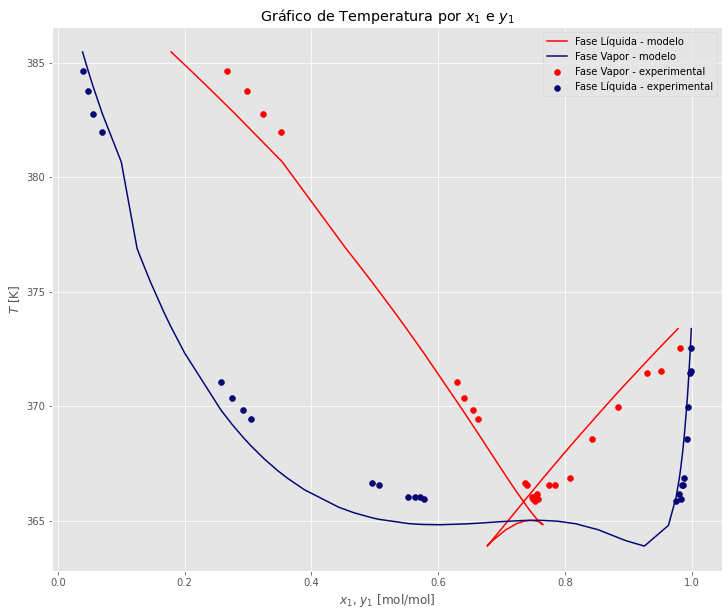

In [66]:
#plt.scatter(x1, T)
#plt.plot(x1, T)

data  = [
    [384.65, 0.03900, 0.26700],
    [383.75, 0.04700, 0.29900],
    [382.75, 0.05500, 0.32300],
    [381.95, 0.07000, 0.35200],
    [371.05, 0.25700, 0.62900],
    [370.35, 0.27500, 0.64100],
    [369.85, 0.29200, 0.65500],
    [369.45, 0.30500, 0.66200],
    [366.65, 0.49600, 0.73600],
    [366.55, 0.50600, 0.74000],
    [366.05, 0.55200, 0.75000],
    [366.05, 0.56400, 0.75200],
    [366.05, 0.57100, 0.74800],
    [365.95, 0.57700, 0.75000],
    [365.85, 0.97500, 0.75200],
    [366.15, 0.98000, 0.75600],
    [365.95, 0.98200, 0.75800],
    [366.55, 0.98500, 0.77500],
    [366.55, 0.98600, 0.78400],
    [366.85, 0.98800, 0.80800],
    [368.55, 0.99200, 0.84300],
    [369.95, 0.99400, 0.88400],
    [371.45, 0.99700, 0.92900],
    [371.55, 0.99800, 0.95100],
    [372.55, 0.99900, 0.98100],
]

Texp = []
x1exp = []
y1exp = []
for i in data:
  Texp.append(i[0])
  x1exp.append(i[1])
  y1exp.append(i[2])

fig=plt.figure(figsize=(12, 10))
plt.style.use('ggplot')
plt.scatter(y1exp,  Texp, color='#FF0000')
plt.scatter(x1exp, Texp, color = '#070675')
plt.plot(y,  df['T_pred'], color='#FF0000')
plt.plot(df['x1'], df['T_pred'], color = '#070675')
plt.title("Gráfico de Temperatura por $x_1$ e $y_1$")
plt.xlabel('$x_1$, $y_1$ [mol/mol]')
plt.ylabel('$T$ [K]')
plt.legend(['Fase Líquida - modelo','Fase Vapor - modelo','Fase Vapor - experimental','Fase Líquida - experimental'])


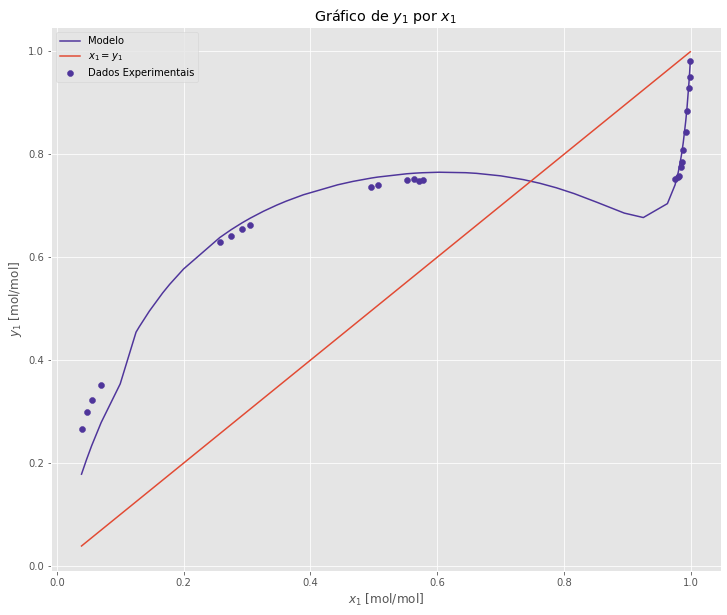

In [67]:
fig=plt.figure(figsize=(12, 10))
plt.plot(x1, y, color = '#4F359B')
plt.scatter(x1exp, y1exp, color = '#4F359B')
plt.plot(x1, x1)
plt.title('Gráfico de $y_1$ por $x_1$')
plt.xlabel('$x_1$ [mol/mol]')
plt.ylabel('$y_1$ [mol/mol]')
plt.legend(['Modelo', '$x_1=y_1$', 'Dados Experimentais',])

## Análise somente com os dados experimentais e com os modelos

In [68]:
#x1 = np.linspace(0,1,50) # entrada de xi
#T = np.linspace(366.85000,372.950000,50) # chute de T verificar se aleatório não é melhor

data  = [
    [384.65, 0.03900, 0.26700],
    [383.75, 0.04700, 0.29900],
    [382.75, 0.05500, 0.32300],
    [381.95, 0.07000, 0.35200],
    [371.05, 0.25700, 0.62900],
    [370.35, 0.27500, 0.64100],
    [369.85, 0.29200, 0.65500],
    [369.45, 0.30500, 0.66200],
    [366.65, 0.49600, 0.73600],
    [366.55, 0.50600, 0.74000],
    [366.05, 0.55200, 0.75000],
    [366.05, 0.56400, 0.75200],
    [366.05, 0.57100, 0.74800],
    [365.95, 0.57700, 0.75000],
    [365.85, 0.97500, 0.75200],
    [366.15, 0.98000, 0.75600],
    [365.95, 0.98200, 0.75800],
    [366.55, 0.98500, 0.77500],
    [366.55, 0.98600, 0.78400],
    [366.85, 0.98800, 0.80800],
    [368.55, 0.99200, 0.84300],
    [369.95, 0.99400, 0.88400],
    [371.45, 0.99700, 0.92900],
    [371.55, 0.99800, 0.95100],
    [372.55, 0.99900, 0.98100],
]



phi1 = []
phi2 = []
gamma1 = []
gamma2 = []
Psat1 = []
Psat2 = []
phisat1 = []
phisat2 = []
FP1 = []
FP2 = []
y1_pred = []
y2_pred = []
T_pred = []
y = []
for i in range(len(data)):
  x1 = data[i][1]
  T = data[i][0]
  mask1, mask2 = Peng_Robinson_Mixture(T, x1)
  mask3, mask4 = Uniquac(T, x1)
  phi1.append(mask1)
  phi2.append(mask2)
  gamma1.append(mask3)
  gamma2.append(mask4)
  mask5 = Antoine_Water(T)
  mask6 = Antoine_Butanol(T)
  Psat1.append(mask5)
  Psat2.append(mask6)
  mask7 = Peng_Robinson_PhiSat(T, mask5)[0]
  phisat1.append(mask7)
  mask9 = Peng_Robinson_PhiSat(T, mask6)[1]
  phisat2.append(mask9)
  fp1, fp2 = poynting(T)
  FP1.append(fp1)
  FP2.append(fp2)
  y1 = (x1*mask3*mask7*mask5*fp1)/(mask1*P)
  y1_pred.append(y1)
  y2 = ((1-x1)*mask4*mask9*mask6*fp2)/(mask2*P)
  y2_pred.append(y2)
  z = fsolve(f,[T, y1, y2], args=(x1,P))
  T_pred.append(z[0])
  y.append(z[1])


df = pd.DataFrame(data, columns = ['T', 'x1', 'y1'])
df['x2'] = 1 - df['x1']
df['phi1'] = phi1
df['phi2'] = phi2
df['gamma1'] = gamma1
df['gamma2'] = gamma2
df['Psat1'] = Psat1
df['Psat2'] = Psat2
df['y1_pred'] = y1_pred
df['y2_pred'] = y2_pred
df['phisat1'] = phisat1
df['phisat2'] = phisat2
df['FP1'] = FP1
df['FP2'] = FP2
df['T_pred'] = T_pred
df['y_pred'] = y

df

,T,x1,y1,x2,phi1,phi2,gamma1,gamma2,Psat1,Psat2,y1_pred,y2_pred,phisat1,phisat2,FP1,FP2,T_pred,y_pred
0,384.65,0.039,0.267,0.961,1.009336,0.959959,3.556330,1.000759,128776.705758,80629.432618,0.172842,0.777294,0.989888,0.974479,0.999846,1.000592,385.463927,0.178532
1,383.75,0.047,0.299,0.953,1.009347,0.960071,3.535468,1.001117,123913.499722,78003.707728,0.199322,0.746467,0.990208,0.975143,0.999873,1.000669,384.714113,0.207197
2,382.75,0.055,0.323,0.945,1.009365,0.960155,3.515228,1.001549,118672.807394,75168.244954,0.222187,0.714128,0.990557,0.975866,0.999902,1.000753,384.005891,0.233811
3,381.95,0.070,0.352,0.930,1.009335,0.960650,3.468542,1.002565,114601.510397,72960.786560,0.269543,0.682936,0.990829,0.976434,0.999925,1.000818,382.779235,0.278891
4,371.05,0.257,0.629,0.743,1.009014,0.967248,2.875065,1.047067,92680.636819,47784.220340,0.664451,0.373525,0.991988,0.983236,1.000050,1.001589,369.838167,0.638135
5,370.35,0.275,0.641,0.725,1.008961,0.968047,2.815004,1.055683,90416.756455,46450.052845,0.679282,0.357073,0.992144,0.983617,1.000064,1.001632,369.195756,0.653482
6,369.85,0.292,0.655,0.708,1.008901,0.968851,2.757567,1.064777,88827.461452,45515.948270,0.694263,0.344449,0.992254,0.983884,1.000073,1.001662,368.643325,0.666587
7,369.45,0.305,0.662,0.695,1.008856,0.969467,2.713843,1.072426,87572.491934,44779.835620,0.703689,0.334914,0.992342,0.984096,1.000081,1.001686,368.254275,0.675785
8,366.65,0.496,0.736,0.504,1.007999,0.979573,2.082500,1.292215,79186.702323,39896.467079,0.795240,0.258459,0.992934,0.985522,1.000131,1.001846,365.121436,0.753742
9,366.55,0.506,0.740,0.494,1.007951,0.980125,2.051074,1.312327,78899.814882,39730.536264,0.796191,0.256074,0.992954,0.985571,1.000132,1.001851,365.060779,0.755632


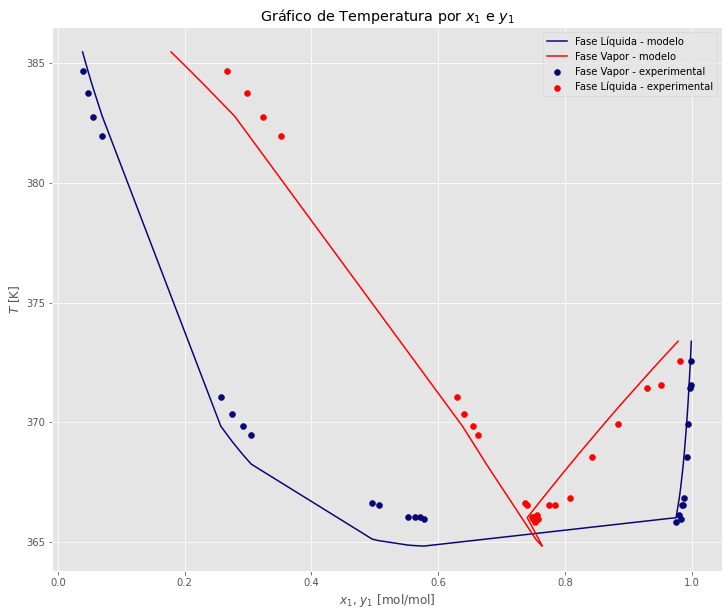

In [69]:
fig=plt.figure(figsize=(12, 10))
plt.scatter(df['x1'], df['T'], color = '#070675')
plt.scatter(df['y1'], df['T'], color = '#FF0000')
plt.plot(df['x1'], df['T_pred'], color = '#070675')
plt.plot(df['y_pred'], df['T_pred'], color = '#FF0000')
plt.title("Gráfico de Temperatura por $x_1$ e $y_1$")
plt.xlabel('$x_1$, $y_1$ [mol/mol]')
plt.ylabel('$T$ [K]')
plt.legend(['Fase Líquida - modelo','Fase Vapor - modelo','Fase Vapor - experimental','Fase Líquida - experimental'])

### Médias Estatísticas

In [75]:
r2 = r2_score(df['T'], df['T_pred'])
mse = mean_squared_error(df['T'], df['T_pred'])

print(r2)
print(mse)
print(mse**0.5)

0.9595299450288742
1.433304302400256
1.197206875356242


In [77]:
r2 = r2_score(df['y1'], df['y_pred'])
mse = mean_squared_error(df['y1'], df['y_pred'])

print(r2)
print(mse)
print(mse**0.5)

0.9631233531291776
0.001355069265915239
0.03681126547560188


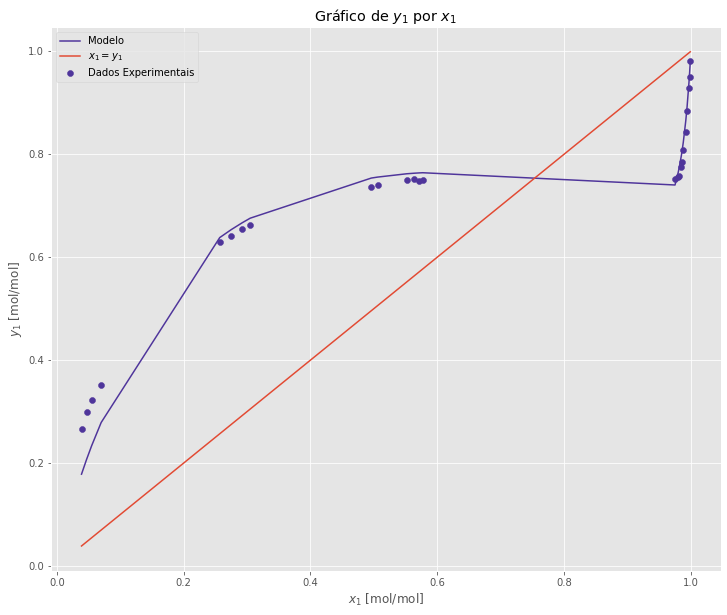

In [71]:
fig=plt.figure(figsize=(12, 10))
plt.plot(df['x1'], df['y_pred'], color = '#4F359B')
plt.scatter(df['x1'], df['y1'], color = '#4F359B')
plt.plot(df['x1'], df['x1'])
plt.title('Gráfico de $y_1$ por $x_1$')
plt.xlabel('$x_1$ [mol/mol]')
plt.ylabel('$y_1$ [mol/mol]')
plt.legend(['Modelo', '$x_1=y_1$', 'Dados Experimentais',])

## Gráfico com somente dados experimentais

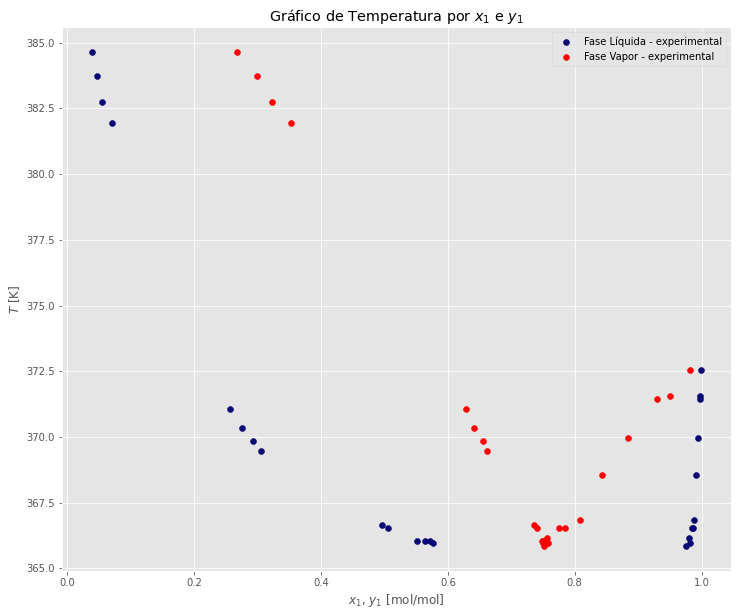

In [72]:
fig=plt.figure(figsize=(12, 10))
plt.scatter(df['x1'], df['T'], color = '#070675')
plt.scatter(df['y1'], df['T'], color = '#FF0000')
plt.title("Gráfico de Temperatura por $x_1$ e $y_1$")
plt.xlabel('$x_1$, $y_1$ [mol/mol]')
plt.ylabel('$T$ [K]')
plt.legend(['Fase Líquida - experimental', 'Fase Vapor - experimental'])

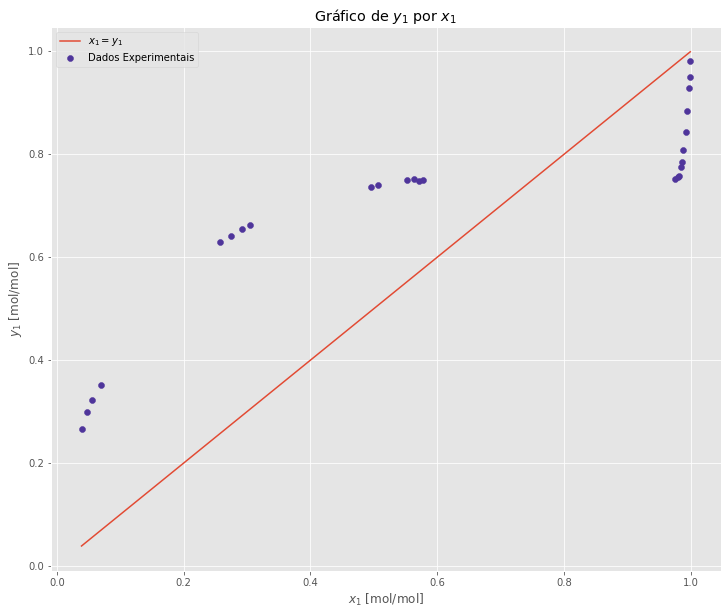

In [73]:
fig=plt.figure(figsize=(12, 10))
plt.scatter(df['x1'], df['y1'], color = '#4F359B')
plt.plot(df['x1'], df['x1'])
plt.title('Gráfico de $y_1$ por $x_1$')
plt.xlabel('$x_1$ [mol/mol]')
plt.ylabel('$y_1$ [mol/mol]')
plt.legend(['$x_1=y_1$','Dados Experimentais'])